## 1. Introduction

This notebook demonstrates the end-to-end process of building a customer propensity model for an e-commerce platform. The goal is to predict whether a user will place an order based on their session and behavioral features.

We explore multiple models (Random Forest, Logistic Regression, XGBoost), handle class imbalance, and validate our approach using both real and business-relevant test cases.


## 2. Data Loading & Exploration

We start by loading the training data and exploring its structure, including class imbalance and feature description.


In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv('training_sample.csv')
print('Shape:', df.shape)
df.head()

Shape: (455401, 25)


,UserID,basket_icon_click,basket_add_list,basket_add_detail,sort_by,image_picker,account_page_click,promo_banner_click,detail_wishlist_add,list_size_dropdown,...,saw_sizecharts,saw_delivery,saw_account_upgrade,saw_homepage,device_mobile,device_computer,device_tablet,returning_user,loc_uk,ordered
0,a720-6b732349-a720-4862-bd21-644732,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
1,a0c0-6b73247c-a0c0-4bd9-8baa-797356,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
2,86a8-6b735c67-86a8-407b-ba24-333055,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,1,0
3,6a3d-6b736346-6a3d-4085-934b-396834,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,1,0
4,b74a-6b737717-b74a-45c3-8c6a-421140,0,1,0,1,0,0,0,0,1,...,0,0,0,1,0,0,1,0,1,1


## Exploratory Data Analysis (EDA)

Before building our customer propensity models, we performed thorough exploratory data analysis (EDA) to understand the dataset, identify important features, and address potential issues such as missing values, duplicate records, and class imbalance. This section summarizes the key EDA steps and insights that guided our modeling approach.


In [78]:
print("Missing values per column:")
display(df.isnull().sum())

print("\nDuplicate rows:", df.duplicated().sum())
print("Unique UserIDs:", df['UserID'].nunique())

# Drop UserID for feature analysis (keep for reference)
features = df.drop(columns=['UserID'])

print("\nBasic statistics for features:")
display(features.describe().T)


Missing values per column:


UserID                     0
basket_icon_click          0
basket_add_list            0
basket_add_detail          0
sort_by                    0
image_picker               0
account_page_click         0
promo_banner_click         0
detail_wishlist_add        0
list_size_dropdown         0
closed_minibasket_click    0
checked_delivery_detail    0
checked_returns_detail     0
sign_in                    0
saw_checkout               0
saw_sizecharts             0
saw_delivery               0
saw_account_upgrade        0
saw_homepage               0
device_mobile              0
device_computer            0
device_tablet              0
returning_user             0
loc_uk                     0
ordered                    0
dtype: int64


Duplicate rows: 0
Unique UserIDs: 455401

Basic statistics for features:


,count,mean,std,min,25%,50%,75%,max
basket_icon_click,455401.0,0.099150,0.298864,0.0,0.0,0.0,0.0,1.0
basket_add_list,455401.0,0.074521,0.262617,0.0,0.0,0.0,0.0,1.0
basket_add_detail,455401.0,0.112916,0.316490,0.0,0.0,0.0,0.0,1.0
sort_by,455401.0,0.036849,0.188391,0.0,0.0,0.0,0.0,1.0
image_picker,455401.0,0.026735,0.161307,0.0,0.0,0.0,0.0,1.0
account_page_click,455401.0,0.003570,0.059647,0.0,0.0,0.0,0.0,1.0
promo_banner_click,455401.0,0.016208,0.126274,0.0,0.0,0.0,0.0,1.0
detail_wishlist_add,455401.0,0.003511,0.059151,0.0,0.0,0.0,0.0,1.0
list_size_dropdown,455401.0,0.230362,0.421065,0.0,0.0,0.0,0.0,1.0
closed_minibasket_click,455401.0,0.017277,0.130302,0.0,0.0,0.0,0.0,1.0


### Distribution of Binary Features

Most features in the dataset are binary indicators of user actions (e.g., clicked, viewed, added to cart). Understanding how frequently each action occurs helps us identify which behaviors are common or rare among users.


C:\Users\amaan\AppData\Local\Temp\ipykernel_28436\2954219652.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_means.values, y=feature_means.index, palette="viridis")


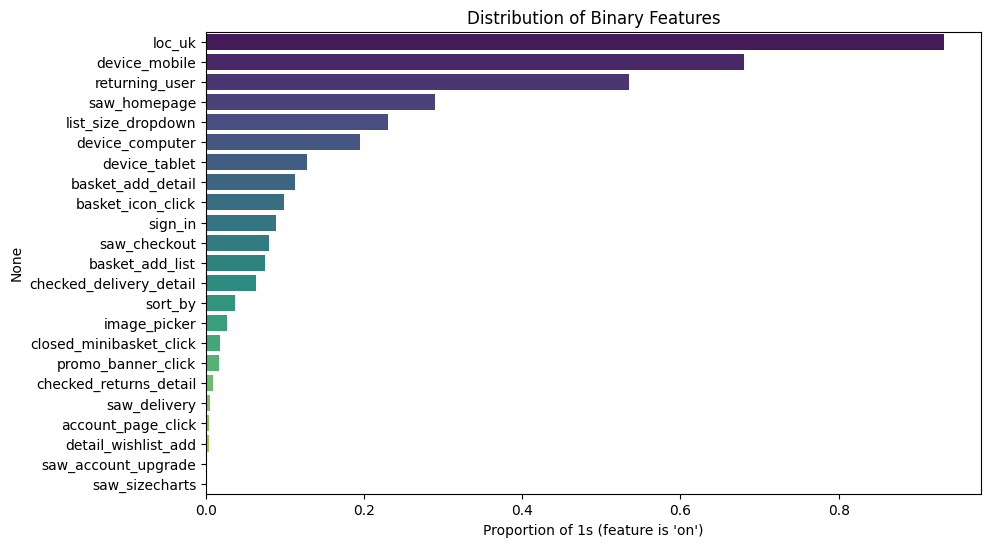

In [79]:
# Exclude UserID and target from feature list
feature_cols = [col for col in df.columns if col not in ['UserID', 'ordered']]

# Calculate proportion of 1s for each feature
feature_means = df[feature_cols].mean().sort_values(ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_means.values, y=feature_means.index, palette="viridis")
plt.xlabel("Proportion of 1s (feature is 'on')")
plt.title("Distribution of Binary Features")
plt.show()


### Feature Differences: Ordered vs. Not Ordered

Comparing feature means for users who placed orders vs. those who did not reveals which actions are most discriminative. This helps us focus on features that truly separate buyers from non-buyers.


,Not Ordered,Ordered,Difference
checked_delivery_detail,0.022317,0.989682,0.967365
saw_checkout,0.039830,1.000000,0.960170
sign_in,0.049204,0.993872,0.944668
basket_add_detail,0.085479,0.739905,0.654426
basket_icon_click,0.072371,0.711098,0.638727
basket_add_list,0.058718,0.435657,0.376939
saw_homepage,0.275047,0.632274,0.357227
list_size_dropdown,0.216721,0.542083,0.325363
returning_user,0.528624,0.678678,0.150054
device_computer,0.190148,0.287278,0.097130


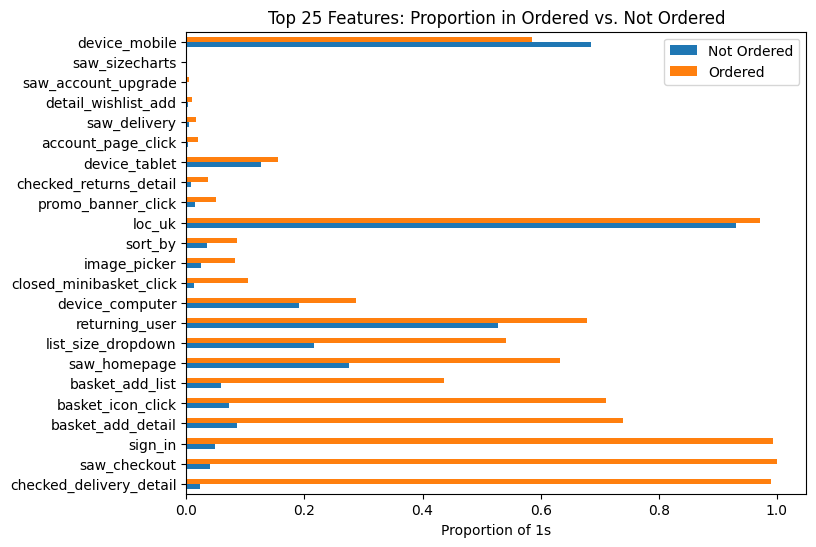

In [80]:
# Calculate mean of each feature for both classes
means_by_target = df.groupby('ordered')[feature_cols].mean().T
means_by_target.columns = ['Not Ordered', 'Ordered']

# Add a column for the difference
means_by_target['Difference'] = means_by_target['Ordered'] - means_by_target['Not Ordered']

# Sort features by how much more common they are in orders
means_by_target = means_by_target.sort_values('Difference', ascending=False)

display(means_by_target)

# Optional: Plot the most discriminative features
top_n = 25
means_by_target.head(top_n)[['Not Ordered', 'Ordered']].plot(kind='barh', figsize=(8,6))
plt.title(f"Top {top_n} Features: Proportion in Ordered vs. Not Ordered")
plt.xlabel("Proportion of 1s")
plt.show()


### Feature Correlation Analysis

Examining correlations between features helps us identify redundancy and multicollinearity, which can impact model performance and interpretability.


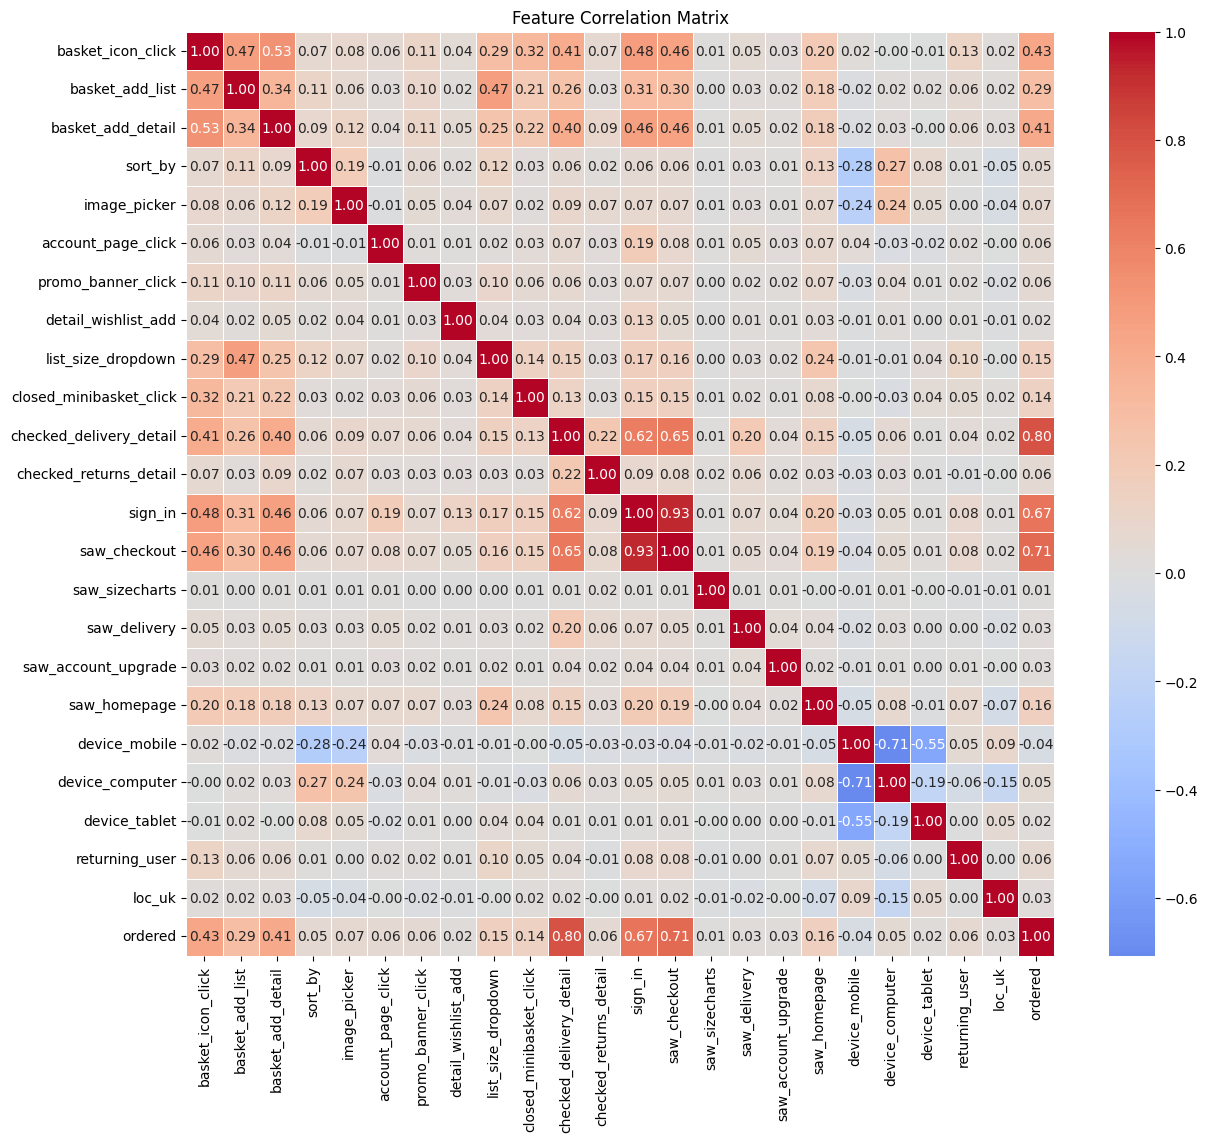

In [81]:
plt.figure(figsize=(14, 12))
corr = features.corr()

# Visualize the full correlation matrix
sns.heatmap(corr, cmap='coolwarm', center=0, annot=True, linewidths=0.5, fmt='.2f')
plt.title("Feature Correlation Matrix")
plt.show()


### Feature Selection

Based on EDA, we identified and dropped features with low value or redundancy:
- saw_sizecharts
- saw_account_upgrade
- saw_delivery
- detail_wishlist_add
- account_page_click
- loc_uk

This streamlined the dataset for more effective modeling.


In [82]:
features_to_drop = [
    'saw_sizecharts',
    'saw_account_upgrade',
    'saw_delivery',
    'detail_wishlist_add',
    'account_page_click',
    'loc_uk'
]

# Create a new DataFrame with these features dropped
df_reduced = df.drop(columns=features_to_drop)

print(f"Columns after dropping: {df_reduced.shape[1]}")
print("Remaining columns:", list(df_reduced.columns))

Columns after dropping: 19
Remaining columns: ['UserID', 'basket_icon_click', 'basket_add_list', 'basket_add_detail', 'sort_by', 'image_picker', 'promo_banner_click', 'list_size_dropdown', 'closed_minibasket_click', 'checked_delivery_detail', 'checked_returns_detail', 'sign_in', 'saw_checkout', 'saw_homepage', 'device_mobile', 'device_computer', 'device_tablet', 'returning_user', 'ordered']


## 3. Model Building & Evaluation
We compare three models: Random Forest, Logistic Regression, and XGBoost. Each is evaluated on a holdout test set and on custom business scenarios.


### Logistic Regression: Hyperparameter Tuning & Evaluation

We use Logistic Regression with hyperparameter tuning (GridSearchCV) and class imbalance handling (class_weight='balanced').  
The model is evaluated on a holdout test set, and we display the best parameters and feature coefficients.

- *Best parameters* are selected based on F1-score.
- *Class imbalance* is addressed to ensure the model does not ignore rare positive cases.
- *Feature coefficients* show which user actions have the strongest positive or negative impact on ordering.


Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best Parameters: {'C': 1, 'max_iter': 200, 'penalty': 'l2', 'solver': 'liblinear'}
              precision    recall  f1-score   support

           0     0.9996    0.9924    0.9960     87262
           1     0.8502    0.9911    0.9152      3819

    accuracy                         0.9923     91081
   macro avg     0.9249    0.9917    0.9556     91081
weighted avg     0.9933    0.9923    0.9926     91081

Confusion matrix:
 [[86595   667]
 [   34  3785]]


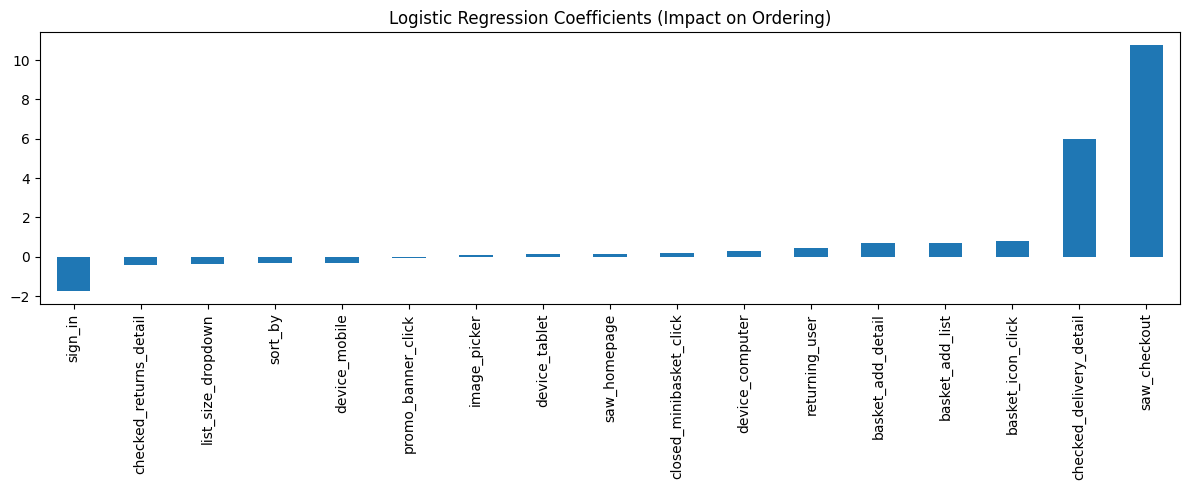

In [83]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Prepare features and target (reuse X, y, X_train, X_test, y_train, y_test if already defined)

# Hyperparameter grid for tuning
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l2'],
    'solver': ['lbfgs', 'liblinear'],
    'max_iter': [200]
}

# Logistic Regression with class_weight='balanced'
lr = LogisticRegression(class_weight='balanced', random_state=42)

# GridSearchCV for best parameters (optimize for F1-score)
grid_search_lr = GridSearchCV(
    lr, param_grid_lr, cv=3, scoring='f1', n_jobs=-1, verbose=2
)
grid_search_lr.fit(X_train, y_train)

# Best model
lr_best = grid_search_lr.best_estimator_
print("Best Parameters:", grid_search_lr.best_params_)

# Evaluate on holdout test set
y_pred_lr = lr_best.predict(X_test)
print(classification_report(y_test, y_pred_lr, digits=4))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred_lr))

# Feature coefficients (sorted)
coef_series = pd.Series(lr_best.coef_[0], index=X.columns)
coef_series.sort_values().plot(kind='bar', figsize=(12,5), title="Logistic Regression Coefficients (Impact on Ordering)")
plt.tight_layout()
plt.show()


In [84]:
# List of features used in your final model
features_to_keep = [
    'basket_icon_click', 'basket_add_list', 'basket_add_detail', 'sort_by', 'image_picker',
    'promo_banner_click', 'list_size_dropdown', 'closed_minibasket_click', 'checked_delivery_detail',
    'checked_returns_detail', 'sign_in', 'saw_checkout', 'saw_homepage', 'device_mobile',
    'device_computer', 'device_tablet', 'returning_user'
]

external_test_cases = [
    # 1. All zeros
    {feature: 0 for feature in features_to_keep},
    # 2. All ones
    {feature: 1 for feature in features_to_keep},
    # 3. Realistic positive: likely to order
    {
        'basket_icon_click': 1, 'basket_add_list': 1, 'basket_add_detail': 1, 'sort_by': 1, 'image_picker': 1,
        'promo_banner_click': 0, 'list_size_dropdown': 1, 'closed_minibasket_click': 1, 'checked_delivery_detail': 1,
        'checked_returns_detail': 1, 'sign_in': 1, 'saw_checkout': 1, 'saw_homepage': 1, 'device_mobile': 1,
        'device_computer': 0, 'device_tablet': 0, 'returning_user': 1
    },
    # 4. Realistic negative: unlikely to order
    {
        'basket_icon_click': 0, 'basket_add_list': 0, 'basket_add_detail': 0, 'sort_by': 0, 'image_picker': 0,
        'promo_banner_click': 1, 'list_size_dropdown': 0, 'closed_minibasket_click': 0, 'checked_delivery_detail': 0,
        'checked_returns_detail': 0, 'sign_in': 0, 'saw_checkout': 0, 'saw_homepage': 1, 'device_mobile': 1,
        'device_computer': 0, 'device_tablet': 0, 'returning_user': 0
    }
]

# Convert to DataFrame and align columns
external_test_df = pd.DataFrame(external_test_cases)
external_test_df = external_test_df.reindex(columns=features_to_keep, fill_value=0)

# Predict using your best logistic regression model
external_preds = lr_best.predict(external_test_df)
external_probas = lr_best.predict_proba(external_test_df)[:, 1]

for i, (pred, proba) in enumerate(zip(external_preds, external_probas), 1):
    print(f"External Test case {i}: {'Ordered' if pred == 1 else 'Not Ordered'} (Probability: {proba:.2f})")

External Test case 1: Not Ordered (Probability: 0.00)
External Test case 2: Ordered (Probability: 1.00)
External Test case 3: Ordered (Probability: 1.00)
External Test case 4: Not Ordered (Probability: 0.00)


### Random Forest Model: Hyperparameter Tuning & Evaluation

We use Random Forest with hyperparameter tuning (GridSearchCV) and class imbalance handling (class_weight='balanced').  
The model is evaluated on a holdout test set, and we display the best parameters and feature importances.

- *Best parameters* are selected based on F1-score.
- *Class imbalance* is addressed to ensure the model does not ignore rare positive cases.
- *Feature importances* show which user actions are most predictive of ordering.

Results below demonstrate the model’s accuracy and business relevance.

Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best Parameters: {'max_depth': 12, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
              precision    recall  f1-score   support

           0     0.9996    0.9925    0.9960     87262
           1     0.8526    0.9903    0.9163      3819

    accuracy                         0.9924     91081
   macro avg     0.9261    0.9914    0.9562     91081
weighted avg     0.9934    0.9924    0.9927     91081

Confusion matrix:
 [[86608   654]
 [   37  3782]]


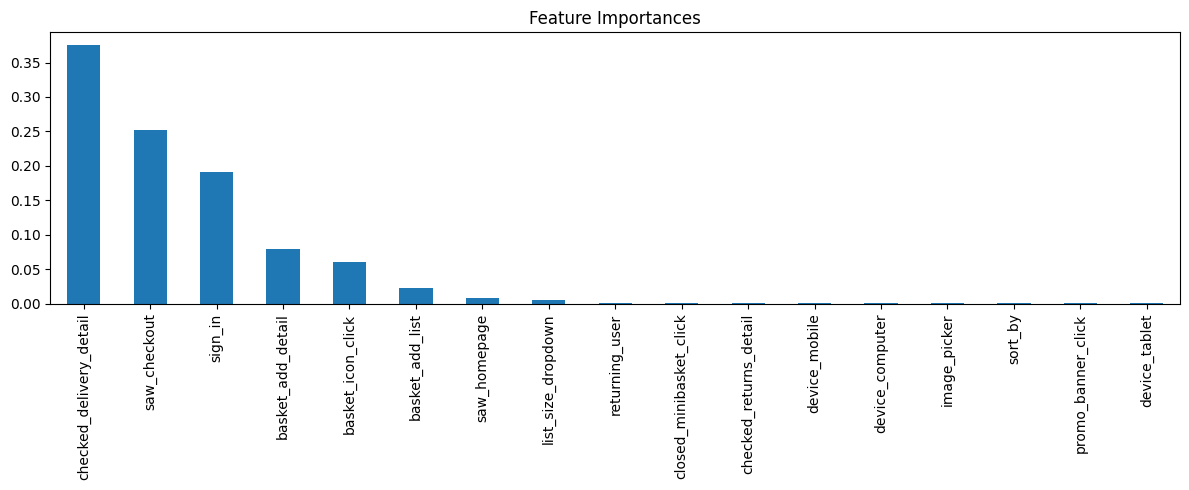

In [85]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import numpy as np

# Prepare features and target
X = df_reduced.drop(columns=['UserID', 'ordered'])
y = df_reduced['ordered']

# Train/test split (stratified for class imbalance)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Hyperparameter grid for tuning
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [8, 12, 16],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

# Random Forest with class_weight='balanced' to handle imbalance
rf = RandomForestClassifier(class_weight='balanced', random_state=42, n_jobs=-1)

# GridSearchCV for best parameters (optimize for F1-score)
grid_search = GridSearchCV(
    rf, param_grid, cv=3, scoring='f1', n_jobs=-1, verbose=2
)
grid_search.fit(X_train, y_train)

# Best model
rf_best = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

# Evaluate on holdout test set
y_pred_rf = rf_best.predict(X_test)
print(classification_report(y_test, y_pred_rf, digits=4))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred_rf))

# Feature importance (sorted)
import matplotlib.pyplot as plt

importances = pd.Series(rf_best.feature_importances_, index=X.columns)
importances.sort_values(ascending=False).plot(kind='bar', figsize=(12,5), title="Feature Importances")
plt.tight_layout()
plt.show()


In [87]:
# List of features used in your final model
features_to_keep = [
    'basket_icon_click', 'basket_add_list', 'basket_add_detail', 'sort_by', 'image_picker',
    'promo_banner_click', 'list_size_dropdown', 'closed_minibasket_click', 'checked_delivery_detail',
    'checked_returns_detail', 'sign_in', 'saw_checkout', 'saw_homepage', 'device_mobile',
    'device_computer', 'device_tablet', 'returning_user'
]

external_test_cases = [
    # 1. All zeros
    {feature: 0 for feature in features_to_keep},
    # 2. All ones
    {feature: 1 for feature in features_to_keep},
    # 3. Realistic positive: likely to order
    {
        'basket_icon_click': 1, 'basket_add_list': 1, 'basket_add_detail': 1, 'sort_by': 1, 'image_picker': 1,
        'promo_banner_click': 0, 'list_size_dropdown': 1, 'closed_minibasket_click': 1, 'checked_delivery_detail': 1,
        'checked_returns_detail': 1, 'sign_in': 1, 'saw_checkout': 1, 'saw_homepage': 1, 'device_mobile': 1,
        'device_computer': 0, 'device_tablet': 0, 'returning_user': 1
    },
    # 4. Realistic negative: unlikely to order
    {
        'basket_icon_click': 0, 'basket_add_list': 0, 'basket_add_detail': 0, 'sort_by': 0, 'image_picker': 0,
        'promo_banner_click': 1, 'list_size_dropdown': 0, 'closed_minibasket_click': 0, 'checked_delivery_detail': 0,
        'checked_returns_detail': 0, 'sign_in': 0, 'saw_checkout': 0, 'saw_homepage': 1, 'device_mobile': 1,
        'device_computer': 0, 'device_tablet': 0, 'returning_user': 0
    }
]

# Convert to DataFrame and align columns
external_test_df = pd.DataFrame(external_test_cases)
external_test_df = external_test_df.reindex(columns=features_to_keep, fill_value=0)

# Predict using your best random forest model
external_preds_rf = rf_best.predict(external_test_df)
external_probas_rf = rf_best.predict_proba(external_test_df)[:, 1]

for i, (pred, proba) in enumerate(zip(external_preds_rf, external_probas_rf), 1):
    print(f"External Test case {i}: {'Ordered' if pred == 1 else 'Not Ordered'} (Probability: {proba:.2f})")

External Test case 1: Not Ordered (Probability: 0.00)
External Test case 2: Ordered (Probability: 0.88)
External Test case 3: Ordered (Probability: 0.91)
External Test case 4: Not Ordered (Probability: 0.00)


### XGBoost: Hyperparameter Tuning & Evaluation

We use XGBoost, a powerful gradient boosting algorithm, with hyperparameter tuning (GridSearchCV) and class imbalance handling (scale_pos_weight).  
The model is evaluated on a holdout test set, and we display the best parameters and feature importances.

- *Best parameters* are selected based on F1-score.
- *Class imbalance* is addressed using the scale_pos_weight parameter.
- *Feature importances* show which user actions most influence the model’s predictions.

Results below demonstrate the model’s accuracy and business relevance.


Fitting 3 folds for each of 72 candidates, totalling 216 fits


c:\Users\amaan\Desktop\c2\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:15:46] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 200, 'subsample': 1.0}
              precision    recall  f1-score   support

           0     0.9996    0.9927    0.9961     87262
           1     0.8565    0.9906    0.9186      3819

    accuracy                         0.9926     91081
   macro avg     0.9280    0.9917    0.9574     91081
weighted avg     0.9936    0.9926    0.9929     91081

Confusion matrix:
 [[86628   634]
 [   36  3783]]


<Figure size 1200x500 with 0 Axes>

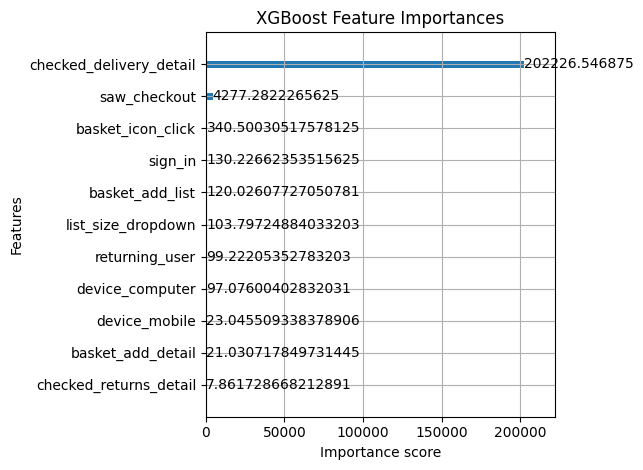

In [88]:
from xgboost import XGBClassifier, plot_importance
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Calculate scale_pos_weight for class imbalance
scale_pos_weight = np.sum(y_train == 0) / np.sum(y_train == 1)

# Hyperparameter grid for tuning
param_grid_xgb = {
    'n_estimators': [100, 200],
    'max_depth': [4, 8, 12],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# XGBoost with scale_pos_weight to handle imbalance
xgb = XGBClassifier(
    objective='binary:logistic',
    scale_pos_weight=scale_pos_weight,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42,
    n_jobs=-1
)

# GridSearchCV for best parameters (optimize for F1-score)
grid_search_xgb = GridSearchCV(
    xgb, param_grid_xgb, cv=3, scoring='f1', n_jobs=-1, verbose=2
)
grid_search_xgb.fit(X_train, y_train)

# Best model
xgb_best = grid_search_xgb.best_estimator_
print("Best Parameters:", grid_search_xgb.best_params_)

# Evaluate on holdout test set
y_pred_xgb = xgb_best.predict(X_test)
print(classification_report(y_test, y_pred_xgb, digits=4))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred_xgb))

# Feature importance (sorted)
plt.figure(figsize=(12,5))
plot_importance(xgb_best, max_num_features=15, importance_type='gain', title='XGBoost Feature Importances')
plt.tight_layout()
plt.show()


In [89]:
# List of features used in your final model
features_to_keep = [
    'basket_icon_click', 'basket_add_list', 'basket_add_detail', 'sort_by', 'image_picker',
    'promo_banner_click', 'list_size_dropdown', 'closed_minibasket_click', 'checked_delivery_detail',
    'checked_returns_detail', 'sign_in', 'saw_checkout', 'saw_homepage', 'device_mobile',
    'device_computer', 'device_tablet', 'returning_user'
]

external_test_cases = [
    # 1. All zeros
    {feature: 0 for feature in features_to_keep},
    # 2. All ones
    {feature: 1 for feature in features_to_keep},
    # 3. Realistic positive: likely to order
    {
        'basket_icon_click': 1, 'basket_add_list': 1, 'basket_add_detail': 1, 'sort_by': 1, 'image_picker': 1,
        'promo_banner_click': 0, 'list_size_dropdown': 1, 'closed_minibasket_click': 1, 'checked_delivery_detail': 1,
        'checked_returns_detail': 1, 'sign_in': 1, 'saw_checkout': 1, 'saw_homepage': 1, 'device_mobile': 1,
        'device_computer': 0, 'device_tablet': 0, 'returning_user': 1
    },
    # 4. Realistic negative: unlikely to order
    {
        'basket_icon_click': 0, 'basket_add_list': 0, 'basket_add_detail': 0, 'sort_by': 0, 'image_picker': 0,
        'promo_banner_click': 1, 'list_size_dropdown': 0, 'closed_minibasket_click': 0, 'checked_delivery_detail': 0,
        'checked_returns_detail': 0, 'sign_in': 0, 'saw_checkout': 0, 'saw_homepage': 1, 'device_mobile': 1,
        'device_computer': 0, 'device_tablet': 0, 'returning_user': 0
    }
]

# Convert to DataFrame and align columns
external_test_df = pd.DataFrame(external_test_cases)
external_test_df = external_test_df.reindex(columns=features_to_keep, fill_value=0)

# Predict using your best XGBoost model
external_preds_xgb = xgb_best.predict(external_test_df)
external_probas_xgb = xgb_best.predict_proba(external_test_df)[:, 1]

for i, (pred, proba) in enumerate(zip(external_preds_xgb, external_probas_xgb), 1):
    print(f"External Test case {i}: {'Ordered' if pred == 1 else 'Not Ordered'} (Probability: {proba:.2f})")

External Test case 1: Not Ordered (Probability: 0.07)
External Test case 2: Ordered (Probability: 0.92)
External Test case 3: Ordered (Probability: 0.92)
External Test case 4: Not Ordered (Probability: 0.07)
